In [4]:
import tensorflow as tf
import os
from datetime import datetime
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, '../training')
from shared_funcs import multi_label_binary_encode_tensor, multi_label_binary_decode_tensor, get_waveform, split_into_windows, split_into_sequences 

In [5]:
INPUT_AUDIO_DIR = os.path.dirname(os.getcwd()) + "/data-manipulation/supp/input/audio/"
INPUT_META_DIR = os.path.dirname(os.getcwd()) + "/data-manipulation/supp/input/metadata/"

if not os.path.exists(INPUT_AUDIO_DIR):
    os.makedirs(INPUT_AUDIO_DIR)
if not os.path.exists(INPUT_META_DIR):
    os.makedirs(INPUT_META_DIR)

## Define functions
Mainly pulled from model.ipynb

In [6]:
ALL_LABELS = tf.constant(['Rctrl', 'p', 'esc', 'g', 'slash', 'down', '7', 'equal', 'w', 'a', 'dash', 'caps', 'l', 'd', 'backspace', 'bracketclose', 'z', '1', 'end', 'Rshift', 'comma', 'c', 'tab', 'b', 'j', 'right', 'Lctrl', 'n', 't', 'f', 'm', 'o', 'apostrophe', 'y', '8', 'space', 'backslash', 's', '9', 'i', 'r', 'bracketopen', 'semicolon', 'q', '5', 'k', '3', 'x', '4', '6', '2', 'Lshift', 'left', 'backtick', 'enter', 'fullstop', 'e', '0', 'h', 'v', 'up', 'u', 'delete'], dtype=tf.string)

In [7]:
def load_audio_data():
    data = []
    for file in os.listdir(INPUT_AUDIO_DIR):
        split_fn = file.split("-")
        split_fn[1] = split_fn[1][:-4] # Remove .wav extension
        split_fn[0] = float(split_fn[0])
        split_fn[1] = float(split_fn[1])
        data.append({"start_time": datetime.fromtimestamp(split_fn[0]),
                      "end_time": datetime.fromtimestamp(split_fn[1]),
                        "waveform": get_waveform(INPUT_AUDIO_DIR + file)
        })
    
    return data

def loadMetadata():
    metadata = []
    for file in os.listdir(INPUT_META_DIR):
        with open(INPUT_META_DIR + file, "r") as file:
            fdata = file.readlines()

        for line in fdata:
            line = line.strip("\n").split(",")
            metadata.append({"label": multi_label_binary_encode_tensor(line[0]), "time": datetime.fromtimestamp(float(line[1]))})
    return metadata

# Remove keypresses keylogged outside of recording time
def filterMetadata(audio_data, metadata):
    filtered_metadata = []
    for mdata in metadata:
        for audio_ts in audio_data:
            start_time = audio_ts["start_time"]
            end_time = audio_ts["end_time"]
            timestamp = mdata["time"]
            if start_time <= timestamp <= end_time:
                filtered_metadata.append(mdata)
    return filtered_metadata

def matchMetadataToAudioSlice(audio_slice, metadata):
    matched_metadata = []
    start_time = audio_slice["start_time"]
    end_time = audio_slice["end_time"]

    for mdata in metadata:
        mdata_ts = mdata["time"]
        if start_time <= mdata_ts <= end_time:
            matched_metadata.append(mdata)

    return matched_metadata

In [8]:
# Split waveform into windows, label frames for each window, then turn windows and frames into sequences of 3
def preprocess_waveform_and_label(audio_sample, metadata):
    waveform = audio_sample["waveform"]
    start_time = audio_sample["start_time"]    

    tf.debugging.assert_equal(
        tf.shape(waveform)[0], 
        tf.constant(44100, dtype=tf.int32),
        message="Waveform must have 44100 samples"
    )

    sample_rate = 44100
    frame_length = 2205
    frame_step = 1102
    tolerance_sec = 50 / 1000.0

    # Split waveform into windows
    frames = split_into_windows(waveform, frame_length, frame_step)
    num_frames = tf.shape(frames)[0]

    frame_time_ranges = [
        (i * frame_step / sample_rate, (i * frame_step + frame_length) / sample_rate)
        for i in range(num_frames)
    ]

    # Assign labels
    frame_labels = []
    for frame_start, frame_end in frame_time_ranges:
        frame_labels_binary = tf.zeros(len(ALL_LABELS), dtype=tf.int32)  # Default zero tensor

        for label_data in metadata:
            label_time = (label_data["time"] - start_time).total_seconds()
            if (frame_start - tolerance_sec) <= label_time <= (frame_end + tolerance_sec):
                label_index = tf.where(ALL_LABELS == multi_label_binary_decode_tensor(label_data["label"]))
                if tf.size(label_index) > 0:
                    frame_labels_binary = tf.tensor_scatter_nd_update(
                        frame_labels_binary,
                        indices=[[label_index[0][0]]],
                        updates=[1]
                    )

        frame_labels.append(frame_labels_binary)

    frame_sequences = split_into_sequences(frames, 3)
    label_sequences = split_into_sequences(tf.stack(frame_labels), 3)

    # Debug
    # print("Frames shape:", frame_sequences.shape)
    # print("Labels shape:", label_sequences.shape)

    return frame_sequences, label_sequences

## Preprocess Data

In [9]:
def create_dataset(audio_data, metadata, sequence_length=3):
    def gen():
        for audio_slice in audio_data:
            matched_metadata = matchMetadataToAudioSlice(audio_slice, metadata)
            frame_sequences, label_sequences = preprocess_waveform_and_label(audio_slice, matched_metadata)
            for x, y in zip(frame_sequences, label_sequences):
                yield x, y

    # Create a dataset from the generator
    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(sequence_length, 2205), dtype=tf.float32),  # Frames
            tf.TensorSpec(shape=(sequence_length, 63), dtype=tf.int32)  # Labels
        )
    )
    
    return dataset

In [10]:
audio_data = load_audio_data()
metadata = filterMetadata(audio_data, loadMetadata())

dataset = create_dataset(audio_data, metadata)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset.cache()

print(dataset.element_spec)
print(dataset.reduce(0, lambda x, _: x + 1).numpy())

# dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# for _, label_sequence in dataset.take(1):
#     print([multi_label_binary_decode_tensor(label) for label in label_sequence])


(TensorSpec(shape=(3, 2205), dtype=tf.float32, name=None), TensorSpec(shape=(3, 63), dtype=tf.int32, name=None))
1443


## Preview Data

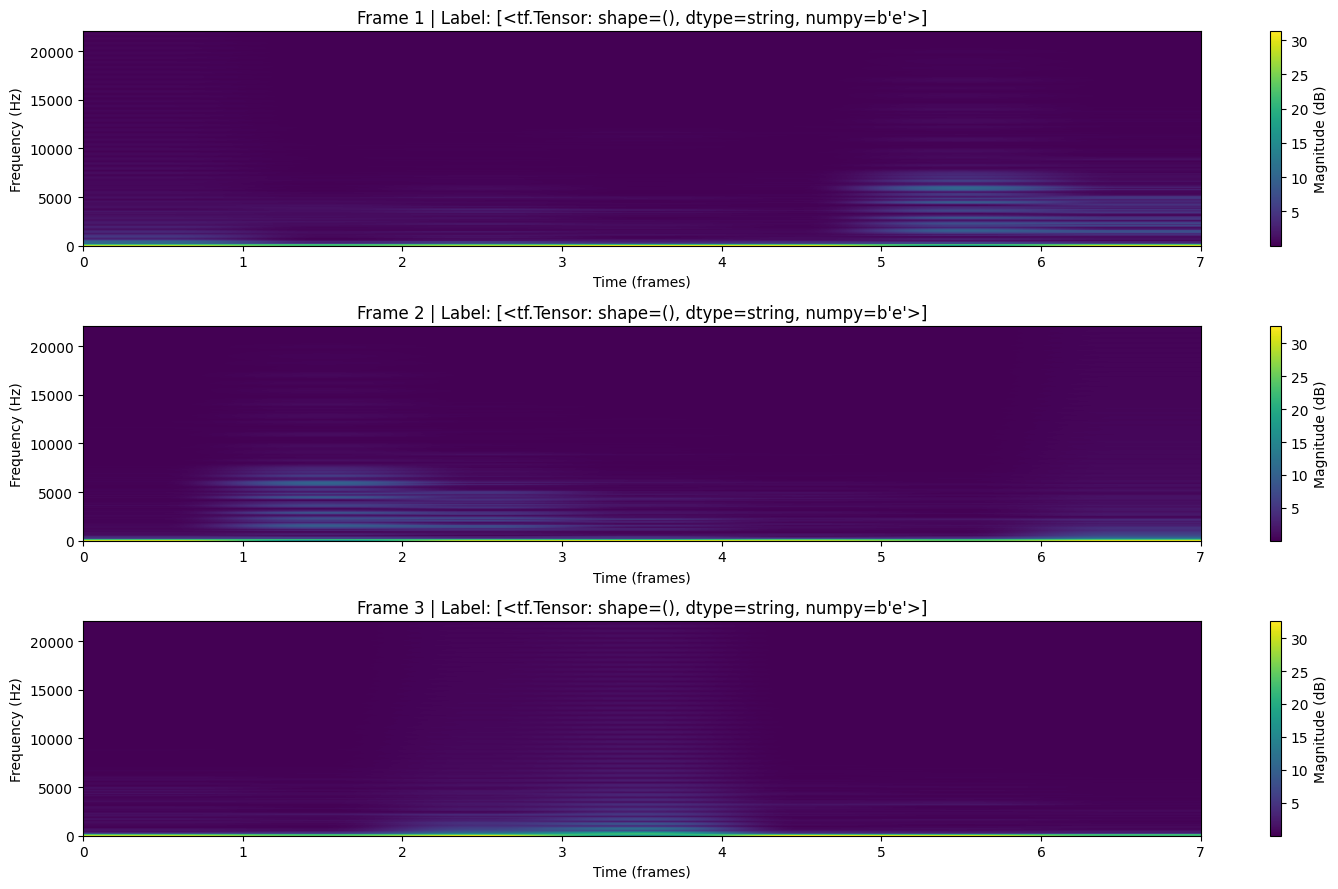

2024-12-01 21:34:30.591073: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
def plot_spectrogram_sequence(sequence, sample_rate=44100, frame_length=2205, frame_step=1102, label=None):
    sequence_length = sequence.shape[0]
    
    plt.figure(figsize=(15, 3 * sequence_length))  # Adjust figure size based on sequence length

    for i, frame in enumerate(sequence):
        # Compute STFT (Short-Time Fourier Transform)
        stft = tf.signal.stft(
            frame,
            frame_length=frame_length // 4,
            frame_step=frame_step // 4,
            fft_length=frame_length // 2,
        )
        
        # Compute magnitude spectrogram
        spectrogram = tf.abs(stft)
        spectrogram = tf.transpose(spectrogram)  # Transpose for better visualization

        # Plot the spectrogram
        plt.subplot(sequence_length, 1, i + 1)
        plt.imshow(
            10 * tf.math.log1p(spectrogram).numpy(),  # Log-scaled spectrogram
            aspect='auto',
            origin='lower',
            extent=[0, spectrogram.shape[1], 0, sample_rate / 2]
        )
        plt.colorbar(label="Magnitude (dB)")
        title = f"Frame {i + 1}"
        if label is not None:
            title += f" | Label: {label[i]}"
        plt.title(title)
        plt.ylabel("Frequency (Hz)")
        plt.xlabel("Time (frames)")

    plt.tight_layout()
    plt.show()

# ds = flattened_ds.shuffle(10000)
for sequence, label_sequence in dataset.take(1):
    plot_spectrogram_sequence(sequence, label=[multi_label_binary_decode_tensor(x) for x in label_sequence])



## Save new dataset

In [12]:
path = os.path.dirname(os.getcwd()) + "/data-manipulation/supp_dataset"

dataset.save(path)